<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [62]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176523 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3553 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/178 [00:00<?, ? examples/s]

In [63]:
data = df_86400
data = data.set_index("timestamp")
#data.head()

In [64]:
train_data = data["2022-12-20":"2023-06-14"]
valid_data = data["2023-06-15":"2023-07-01"]
test_data = data["2023-07-01":]

#### Scaling

In [65]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [66]:
batch_size = 32
num_features = 12
sequence_lenght = 7
prediction_lenght = 7
seed = 42

# Models

## Forecasting one-step-ahead

In [67]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [68]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']

In [69]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0039 - mae: 0.0693 - val_loss: 0.0041 - val_mae: 0.0750
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - mae: 0.0624 - val_loss: 0.0030 - val_mae: 0.0628
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - mae: 0.0514 - val_loss: 0.0021 - val_mae: 0.0552
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - mae: 0.0448 - val_loss: 0.0016 - val_mae: 0.0490
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.0453 - val_loss: 0.0014 - val_mae: 0.0447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0014 - mae: 0.0447


44660.38569808006

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [72]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0022 - mae: 0.0529 - val_loss: 8.2840e-04 - val_mae: 0.0322
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - mae: 0.0450 - val_loss: 9.9070e-04 - val_mae: 0.0416
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0414 - val_loss: 0.0011 - val_mae: 0.0300
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0388 - val_loss: 0.0012 - val_mae: 0.0306
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - mae: 0.0337 - val_loss: 7.9511e-04 - val_mae: 0.0310
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0011 - mae: 0.0300


29976.671561598778

#### Deep RNN

In [74]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [75]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - loss: 0.0075 - mae: 0.0948 - val_loss: 0.0034 - val_mae: 0.0667
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0073 - mae: 0.0978 - val_loss: 0.0047 - val_mae: 0.0845
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0053 - mae: 0.0825 - val_loss: 0.0023 - val_mae: 0.0570
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - mae: 0.0653 - val_loss: 9.7238e-04 - val_mae: 0.0342
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033 - mae: 0.0641 - val_loss: 0.0024 - val_mae: 0.0589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 9.7238e-04 - mae: 0.0342


34190.28967618942

### Multivariate Series

In [76]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [77]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - loss: 0.1324 - mae: 0.4030 - val_loss: 0.0201 - val_mae: 0.1569
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0826 - mae: 0.2929 - val_loss: 0.0119 - val_mae: 0.1225
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0468 - mae: 0.2324 - val_loss: 0.0081 - val_mae: 0.0994
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0368 - mae: 0.2026 - val_loss: 0.0063 - val_mae: 0.0864
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0250 - mae: 0.1638 - val_loss: 0.0057 - val_mae: 0.0732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0057 - mae: 0.0732


73168.7918305397

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

In [79]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


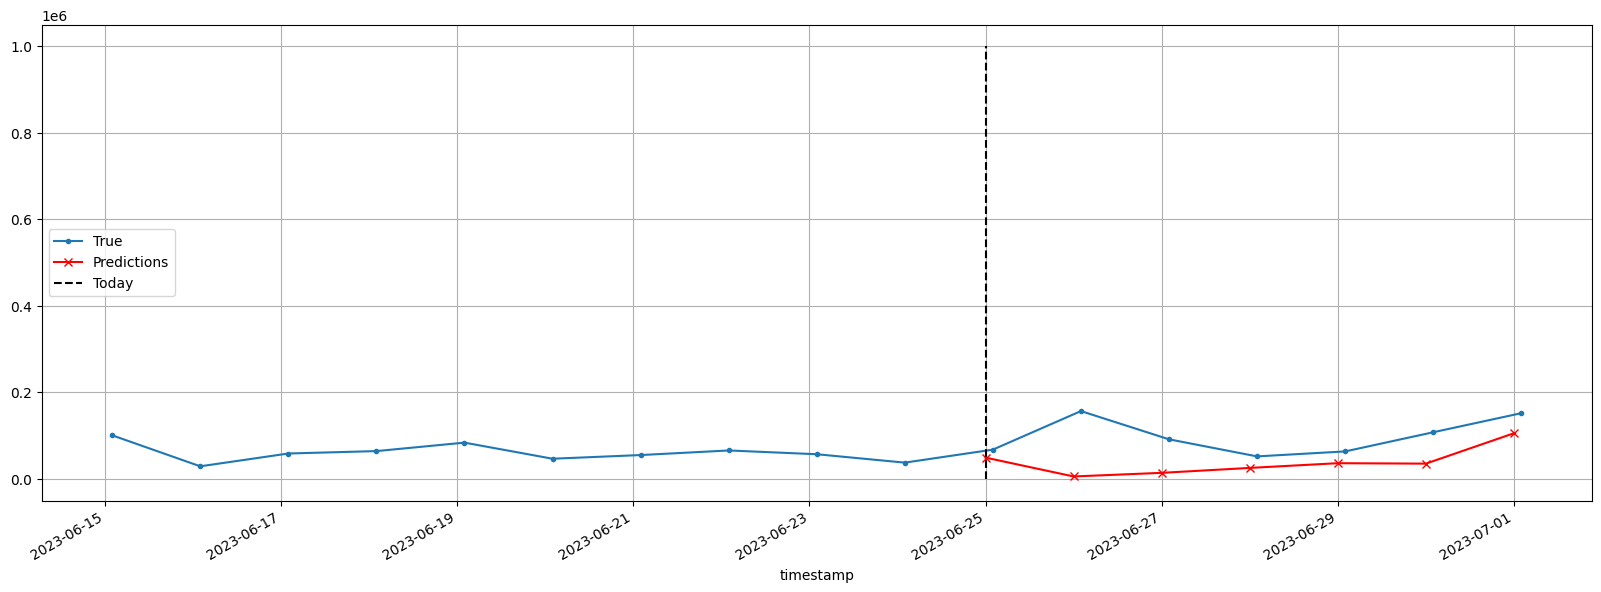

In [80]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [81]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [82]:
print(len(ahead_train_ds))  # Check the size of your training dataset
print(len(ahead_valid_ds))  # Check the size of your validation dataset

5
1


#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [83]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - loss: 0.4544 - mae: 0.8336 - val_loss: 0.3418 - val_mae: 0.7871
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4465 - mae: 0.8222 - val_loss: 0.2985 - val_mae: 0.7311
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4070 - mae: 0.7733 - val_loss: 0.2556 - val_mae: 0.6665
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3974 - mae: 0.7558 - val_loss: 0.2098 - val_mae: 0.5959
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3882 - mae: 0.7390 - val_loss: 0.1702 - val_mae: 0.5276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1702 - mae: 0.5276


527590.3344154358

In [85]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X) # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


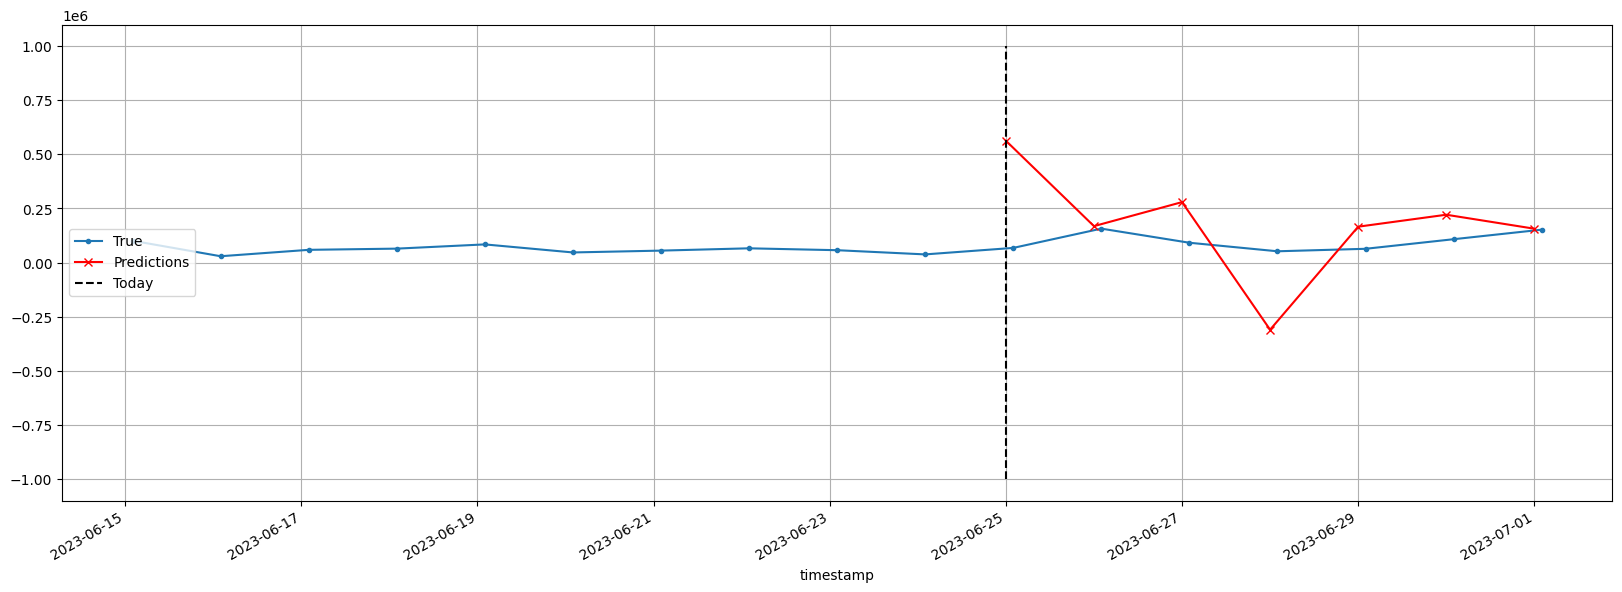

In [86]:
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [87]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [88]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

In [89]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(batch_size, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/5
      1/Unknown 3s 3s/step - loss: 0.5342 - mae: 0.9179

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.5145 - mae: 0.8932 - val_loss: 0.3046 - val_mae: 0.7010
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4835 - mae: 0.8536 - val_loss: 0.2488 - val_mae: 0.6250
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4606 - mae: 0.8223 - val_loss: 0.1966 - val_mae: 0.5491
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4321 - mae: 0.7858 - val_loss: 0.1629 - val_mae: 0.4981
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4222 - mae: 0.7696 - val_loss: 0.1406 - val_mae: 0.4616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1406 - mae: 0.4616


461604.8038005829

In [91]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


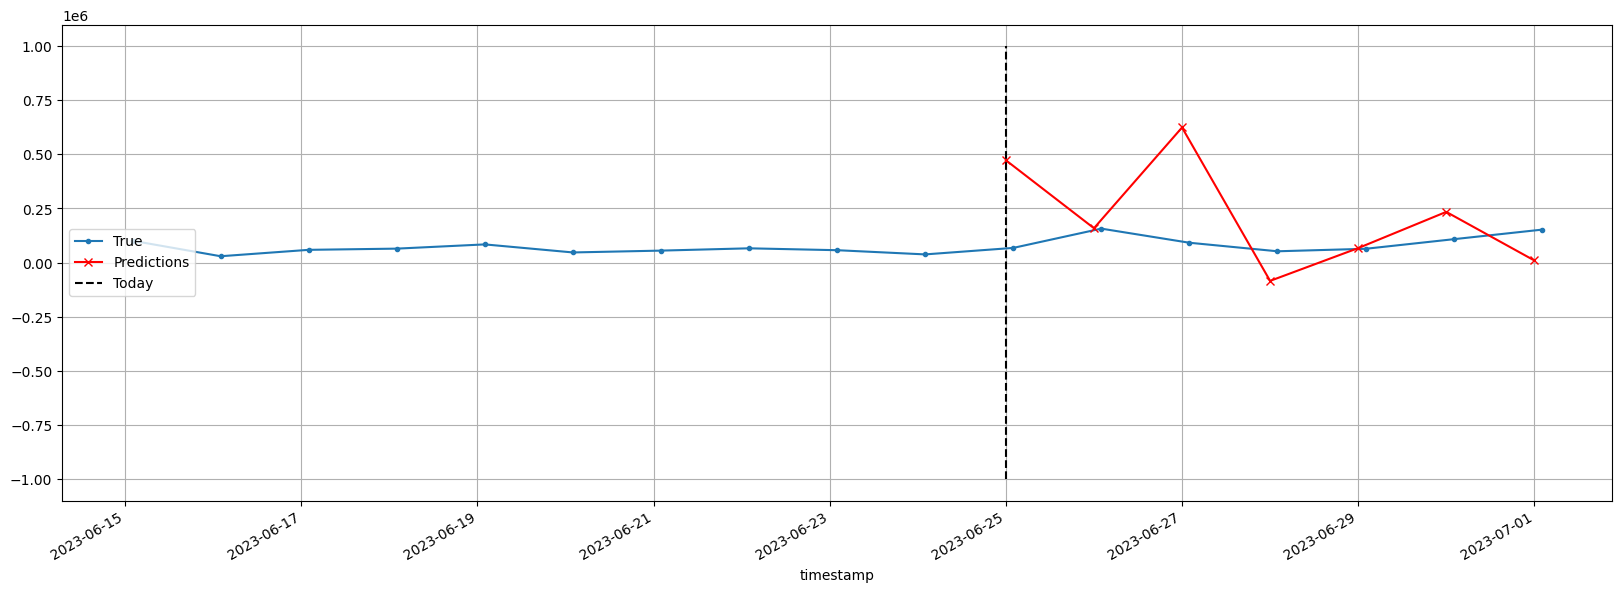

In [92]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()